超とりあえず学習させたけど微妙

10cvは時間かかりすぎ, 5cvで良いわ

5cv, 2seedでやろう

まあBuchetingしたら10cv, 2seedでやってもいいかも

なんかplotしようとしたら落ちる、、、

## model
LSTM->max pooling->ResDense



In [1]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from contextlib import contextmanager
from fastprogress import master_bar, progress_bar
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 2 * LSTM_UNITS
MAX_LEN = 220


In [3]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [4]:
import joblib

In [5]:
%%time
with open('../input/crawl_emb_processed.joblib', 'rb') as f:
    crawl_emb_dict = joblib.load(f)

CPU times: user 1min 19s, sys: 2.73 s, total: 1min 21s
Wall time: 1min 23s


In [6]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [7]:
import re
# これだと、'はembeddingに結構入ってるのに除外されちゃう。　よくないので ' だけ抜いた
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x: str) -> str:
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' {} '.format(punct))
    return x

In [8]:
%%time
# 9.9G
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

x_train = train['comment_text'].apply(lambda x: clean_text(x))
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = test['comment_text'].apply(lambda x: clean_text(x))
del train, test
gc.collect()

CPU times: user 19.7 s, sys: 758 ms, total: 20.5 s
Wall time: 19.8 s


In [9]:
x_train.shape, y_train.shape, y_aux_train.shape, x_test.shape

((1804874,), (1804874,), (1804874, 6), (97320,))

In [10]:
%%time
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

CPU times: user 2min 9s, sys: 441 ms, total: 2min 10s
Wall time: 2min 9s


In [11]:
max_features = len(tokenizer.word_index) + 1
max_features

378798

In [12]:
def build_matrix(word_index, embedding_dict):
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_dict[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words


In [13]:
%%time
emb_mat_crawl, oov = build_matrix(tokenizer.word_index, crawl_emb_dict)

CPU times: user 391 ms, sys: 172 ms, total: 563 ms
Wall time: 562 ms


In [14]:
del crawl_emb_dict
gc.collect()

0

In [15]:
emb_mat_crawl.shape

(378798, 300)

In [16]:
# Kernelでは17414とか
len(oov)

142880

In [17]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        
        # global max pooling
        max_pool, _ = torch.max(h_lstm1, 1)
        
        h_conc_linear1  = F.relu(self.linear1(max_pool))
        
        hidden = max_pool + h_conc_linear1
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [18]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [19]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()

In [20]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

3398565888

In [21]:
batch_size = 512
n_epochs = 10
n_splits = 10
loss_fn=nn.BCEWithLogitsLoss(reduction='mean')
embedding_matrix = emb_mat_crawl

test_dataset = data.TensorDataset(x_test_torch)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits)
seed_dev_loss_list = []
seed_val_loss_list = []
for i_seed in range(8):
    print(f'start seed {i_seed}')
    
    fold_dev_loss_list = []
    fold_val_loss_list = []
    for i_fold, (dev_index, val_index) in enumerate(kf.split(x_train_torch)):
        print(f'start fold {i_fold}')
        model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
        model.cuda()
        print(torch.cuda.memory_allocated())

        optimizer = torch.optim.Adam(model.parameters())

        dev_dataset = data.TensorDataset(x_train_torch[dev_index], y_train_torch[dev_index])
        val_dataset = data.TensorDataset(x_train_torch[val_index], y_train_torch[val_index])

        dev_loader = torch.utils.data.DataLoader(
            dev_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False)

        all_test_preds = []
        mb = master_bar(range(n_epochs))
        dev_loss_list = []
        val_loss_list = []
        for i_epoch in mb:
            start_time = time.time() 
            model.train()
            dev_avg_loss = 0.
            for batch in progress_bar(dev_loader):
                x_batch = batch[:-1]
                y_batch = batch[-1]

                y_pred = model(*x_batch)

                loss = loss_fn(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()
                dev_avg_loss += loss.item() / len(dev_loader)

            dev_loss_list.append(dev_avg_loss)


            model.eval()
            val_avg_loss = 0.
            for batch in progress_bar(val_loader):
                x_batch = batch[:-1]
                y_batch = batch[-1]

                y_pred = model(*x_batch)

                loss = loss_fn(y_pred, y_batch)
                val_avg_loss += loss.item() / len(val_loader)

            val_loss_list.append(val_loss_list)


            elapsed_time = time.time() - start_time
            mb.write(f'Finished epoch {i_epoch} in {elapsed_time: .0f}, dev_loss: {dev_avg_loss}, val_loss: {val_avg_loss}')
        
        fold_dev_loss_list.append(dev_loss_list)
        fold_val_loss_list.append(val_loss_list)
        del dev_dataset, val_dataset, dev_loader, val_loader, model
        gc.collect()
        torch.cuda.empty_cache()
    seed_dev_loss_list.append(fold_dev_loss_list)
    seed_val_loss_list.append(fold_val_loss_list)

start seed 0
start fold 0
3855229952


start fold 1
4450270720


start fold 2
4450532864


start fold 3
4450532864


start fold 4
4450270720


start fold 5
4450131968


start fold 6
4450131968


start fold 7
4450131968


start fold 8
4450131968


start fold 9
4450131968


start seed 1
start fold 0
4450131968


start fold 1
4450270720


start fold 2
4450270720


start fold 3
4450270720


start fold 4
4450270720


start fold 5
4450131968


start fold 6
4450131968


start fold 7
4450131968


start fold 8
4450131968


start fold 9
4450131968


start seed 2
start fold 0
4450131968


start fold 1
4450270720


start fold 2
4450270720


start fold 3
4450270720


start fold 4
4450270720


start fold 5
4450131968


KeyboardInterrupt: 

In [23]:
seed_dev_loss_list[0]

[[0.11627027046509522,
  0.10819474725816429,
  0.1067675779501119,
  0.10586462309598704,
  0.10518805908078525,
  0.10461226533517243,
  0.10413480235402847,
  0.10374019220307017,
  0.10339523765930346,
  0.10303972124010848],
 [0.11684138801217699,
  0.10749227195283101,
  0.1060127405513735,
  0.10511286279642737,
  0.10438479662523871,
  0.10387876412628404,
  0.10335858899535301,
  0.10298801203405972,
  0.10266543852721258,
  0.10226941235267231],
 [0.11635888392311727,
  0.10755883446776304,
  0.10598193646050214,
  0.10504933679813934,
  0.10431506736230436,
  0.10378661662283808,
  0.1033084863486289,
  0.10291754607002025,
  0.10255709429278242,
  0.10224074298815904],
 [0.1155519545233255,
  0.1075478974968111,
  0.10611319296083124,
  0.10520632132263255,
  0.10454839579068356,
  0.10401136317756168,
  0.10358506665831285,
  0.10324947619584712,
  0.10284089336974217,
  0.10255901104328266],
 [0.11636299569731502,
  0.10828290368071332,
  0.10674256781392603,
  0.10577781

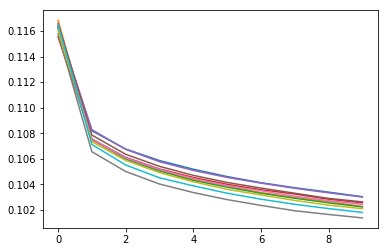

In [28]:
plt.figure()
for dev_loss in seed_dev_loss_list[0]:
    plt.plot(range(10), dev_loss)